In [3]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset



tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

titanic_dataframe = pd.read_csv("titanic/train.csv", sep=",")

titanic_dataframe = titanic_dataframe.reindex(
    np.random.permutation(titanic_dataframe.index))

titanic_dataframe.describe()

# titanic_dataframe = titanic_dataframe[titanic_dataframe["TotRmsAbvGrd"] <= 13]
# titanic_dataframe = titanic_dataframe[titanic_dataframe["OverallQual"] <= 9.5]
# titanic_dataframe = titanic_dataframe[titanic_dataframe["GrLivArea"] <= 3500]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


In [4]:

#     #code categorical data
#     label = LabelEncoder()    
#     dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
#     dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
#     dataset['Title_Code'] = label.fit_transform(dataset['Title'])
#     dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
#     dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#     #define y variable aka target/outcome
#     Target = ['Survived']

#     #define x variables for original features aka feature selection
#     data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
#     data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
#     data1_xy =  Target + data1_x
#     print('Original X Y: ', data1_xy, '\n')


#     #define x variables for original w/bin features to remove continuous variables
#     data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
#     data1_xy_bin = Target + data1_x_bin
#     print('Bin X Y: ', data1_xy_bin, '\n')


#     #define x and y variables for dummy features original
#     data1_dummy = pd.get_dummies(data1[data1_x])
#     data1_x_dummy = data1_dummy.columns.tolist()
#     data1_xy_dummy = Target + data1_x_dummy
#     print('Dummy X Y: ', data1_xy_dummy, '\n')



#     data1_dummy.head()

In [5]:
def fill_na(correlation_dataframe):  
    #complete missing age with median
    correlation_dataframe['Age'].fillna(correlation_dataframe['Age'].median(), inplace = True)

    #complete embarked with mode
    correlation_dataframe['Embarked'].fillna(correlation_dataframe['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    correlation_dataframe['Fare'].fillna(correlation_dataframe['Fare'].median(), inplace = True)

#     #delete the cabin feature/column and others previously stated to exclude in train correlation_dataframe
#     drop_column = ['Cabin', 'Ticket']#'PassengerId',
#     correlation_dataframe.drop(drop_column, axis=1, inplace = True)

    print(correlation_dataframe.isnull().sum())
    print("-"*10)
    print(correlation_dataframe.isnull().sum())
    return correlation_dataframe

In [6]:
def clean_df(correlation_dataframe, fill):
    if fill:
        correlation_dataframe = fill_na(correlation_dataframe)

    correlation_dataframe['FamilySize'] = correlation_dataframe ['SibSp'] + correlation_dataframe['Parch'] + 1

    correlation_dataframe['IsAlone'] = 1 #initialize to yes/1 is alone
    correlation_dataframe['IsAlone'].loc[correlation_dataframe['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    correlation_dataframe['Title'] = correlation_dataframe['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

#     correlation_dataframe['FareBin'] = pd.qcut(correlation_dataframe['Fare'], 4)

#     correlation_dataframe['AgeBin'] = pd.cut(correlation_dataframe['Age'].astype(int), 5)
        
    #cleanup rare title names
    #print(data1['Title'].value_counts())
    stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
    title_names = (correlation_dataframe['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

    #apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
    correlation_dataframe['Title'] = correlation_dataframe['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    print(correlation_dataframe['Title'].value_counts())
        
      #     put back in
    new = pd.DataFrame(correlation_dataframe)#.copy#.corr()
    new = pd.concat([correlation_dataframe, pd.get_dummies(correlation_dataframe['SibSp']).rename(columns={0:"SS0", 1:'SS1', 2:'SS2'}),
                 pd.get_dummies(correlation_dataframe['Parch'])[0:2].rename(columns={0:"PC0", 1:'PC1', 2:'PC2'}),
                 pd.get_dummies(correlation_dataframe['Sex']), pd.get_dummies(correlation_dataframe['Embarked']),
                pd.get_dummies(correlation_dataframe['Pclass']).rename(columns={1:'Class1', 2:'Class2', 3:"Class3"}),
                pd.get_dummies(correlation_dataframe['Title'])],
                axis=1)
    new = new.dropna(axis=1)
    
    print("-"*10)


    #preview data again
    new.info()
    new.info()
    new.sample(10)
        
    return new

In [7]:
def preprocess_dataframe(titanic_dataframe, fill):
  correlation_dataframe = clean_df(titanic_dataframe, fill)#titanic_dataframe.copy()
#   correlation_dataframe["target"] = correlation_dataframe["Survived"]
#   if drop:#creat drop function
#     plt.scatter(correlation_dataframe['Age'], correlation_dataframe["target"])
    
#     correlation_dataframe = clean_df(correlation_dataframe)

#     correlation_dataframe = correlation_dataframe.dropna(subset = ['Age'])# correlation_dataframe['Age'].dropna()
#     correlation_dataframe = correlation_dataframe.drop(['Cabin'], axis=1)# correlation_dataframe['Fare'].dropna()
#     correlation_dataframe = correlation_dataframe.dropna(subset = ['Embarked'])

    
  return correlation_dataframe

def preprocess_features(correlation_dataframe, fill):#, features):
  """Prepares input features from California housing data set.

  Args:
    titanic_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """


  new = correlation_dataframe.copy()#clean_df(correlation_dataframe, fill)

  print(new.head(7))
  new["target"] = new["Survived"]
#   new.set_index('PassengerId')
  new1 = new.corr()
  features_i = new1['Survived'].sort_values(ascending=False).head(16)
#   print("Hello!", correlation_dataframe['IsAlone'].isnull().sum())
#   features_i = pd.concat([features_i, new['IsAlone']], axis=1)#, new['Age']
#   featurs_i = features_i.append(new['IsAlone'])
#   features_i

  # new.hist(figsize=(20,20))
  # print(features)
  features_index = features_i.index[2:]
  print("\nChosen Features NULLs?\n\n", new[features_index].isnull().sum())

  selected_features = new[features_index]
  processed_features = selected_features.copy()

#   processed_features = processed_features.drop(['target','Survived'], axis=1)# 
#Simple version
#   processed_features = pd.DataFrame()
#   processed_features['Fare'] = titanic_dataframe['Fare']
  print(features_index)

  return processed_features, features_index

def preprocess_test_features(correlation_dataframe, features_index, PID):


  new = correlation_dataframe.copy()#clean_df(correlation_dataframe, 1)#correlation_dataframe.copy()#clean_df(correlation_dataframe)

  selected_features = new[features_index]
#   selected_features = pd.concat([new[features_index], correlation_dataframe['PassengerId']], axis=1)
#   new.set_index(PID)
  processed_features = selected_features.copy()
#   processed_features = processed_features.drop(['Survived'], axis=1)
  return processed_features

def preprocess_targets(correlation_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    titanic_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """

  output_targets = pd.DataFrame()
#   output_targets['PassengerId'] = correlation_dataframe['PassengerId']
  output_targets["Survived"] = correlation_dataframe["Survived"]
#   output_targets.set_index('PassengerId')
  return output_targets
# titanic_dataframe

In [8]:
# # Choose the first 12000 (out of 17000) examples for training.
# correlation_df = preprocess_dataframe(titanic_dataframe, 1)

# examples, features_index = preprocess_features(correlation_df, 1)
# training_examples = examples.head(691)#preprocess_features(correlation_df.head(691), 1)
# training_targets = preprocess_targets(correlation_df.head(691))#, 1)
# #
# # correlation_dataframe = titanic_dataframe.copy()
# # correlation_dataframe["target"] = training_targets["SalePrice"]
# # new = correlation_dataframe.corr()
# # print(new)
# # features1 = new['target'].sort_values(ascending=False).head(10).index
# # features1 = features1[2:-1]
# # #
# # training_examples = preprocess_features(titanic_dataframe.head(1000), features1)

# # Choose the last 5000 (out of 17000) examples for validation.
# validation_examples = examples.head(460)#preprocess_features(correlation_df.tail(460), 1)#, features1)
# validation_targets = preprocess_targets(correlation_df.tail(460))#, 1)

# # display.display(titanic_dataframe.describe())

# # Double-check that we've done the right thing.
# print("Training examples summary:")
# display.display(training_examples)#.describe())
# print("Validation examples summary:")
# display.display(validation_examples.describe())

# print("Training targets summary:")
# display.display(training_targets.describe())
# print("Validation targets summary:")
# display.display(validation_targets.describe())


In [9]:
# #find good feratures based on sale price
# correlation_dataframe = titanic_dataframe.copy()
# correlation_dataframe["target"] = titanic_dataframe["SalePrice"]

# # display.display(training_targets.describe())

# correlation_dataframe.corr()
# new = pd.DataFrame()
# new['target'] = correlation_dataframe.corr()['target']
# new.to_csv('corr.csv')
# # correlation_dataframe["OpenPorchSF"].corr()

In [10]:
# correlation_dataframe = titanic_dataframe.copy()
# correlation_dataframe["target"] = training_targets["SalePrice"]

# # display.display(training_targets.describe())
# # pd.options.display.max_rows = 20

# new = correlation_dataframe.corr()
# print(new['target'].sort_values(ascending=False).head(10))#.index)


In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [13]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Survived"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Survived"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Survived"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
#     training_guess = np.array([item['class_ids'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
#     validation_guess = np.array([item['class_ids'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier, predict_validation_input_fn

In [14]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [15]:
def normalize_linear_scale(examples_dataframe):#, features1):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
    
#   examples_dataframe = examples_dataframe[examples_dataframe["TotRmsAbvGrd"] <= 13]
#   examples_dataframe = examples_dataframe[examples_dataframe["OverallQual"] <= 9.5]
#   examples_dataframe = examples_dataframe[examples_dataframe["GrLivArea"] <= 3500]

#   examples_dataframe.dropna()

  new = pd.DataFrame()
  for i in examples_dataframe.columns:
#     print(examples_dataframe[i])
    new = pd.concat([new, linear_scale(examples_dataframe[i])], axis=1)
  
  return new#examples_dataframe.apply(lambda x: linear_scale(x))

# def find_na(df):
#     l = []
#     for label in df.columns:
#         df.dropna()
# #         if df[label].dropna().shape[0] != df.shape[0]:
# #             l.append(label)
#     return df

correlation_df2 = preprocess_dataframe(titanic_dataframe, 1)#, features1)
correlation_df2 = correlation_df2[correlation_df2['male'] == 0]
print("NULL", correlation_df2.isnull().sum())


normalized_dataframe, features_index = preprocess_features(correlation_df2, 1)#correlation_df2)
normalized_dataframe = normalized_dataframe.drop(['PassengerId', 5], axis=1)
# print(normalized_dataframe['IsAlone'].describe())
# normalized_dataframe.dropna()
# print(normalized_dataframe.isnull().sum())
normalized_training_examples = normalize_linear_scale(normalized_dataframe.head(1000))
new_training_targets = preprocess_targets(correlation_df2.head(1000))

normalized_validation_examples = normalize_linear_scale(normalized_dataframe.tail(460))
new_validation_targets = preprocess_targets(correlation_df2.head(460))

print("YESSS\n", normalized_training_examples)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
              ... 
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
----------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
              ... 
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 34 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non

/home/harrisonfsmith95/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Training model...
LogLoss (on training data):
  period 00 : 0.30
  period 01 : 0.30
  period 02 : 0.29
  period 03 : 0.28
  period 04 : 0.28
  period 05 : 0.28
  period 06 : 0.28
  period 07 : 0.28
  period 08 : 0.28
  period 09 : 0.28
Model training finished.
AUC on the validation set: 0.93
Accuracy on the validation set: 0.88


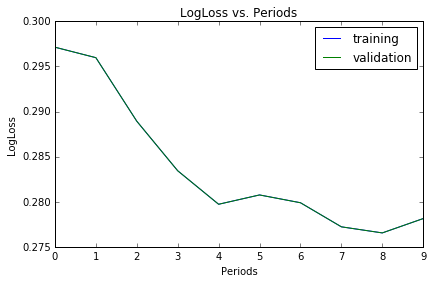

In [16]:
# index1 = list(normalized_training_examples.index.values)
# # print(indexs)
# index2 = list(normalized_validation_examples.index.values)

# print(normalized_training_examples)
# print(normalized_validation_examples)

linear_classifier, predict_validation_input_fn = train_linear_classifier_model(
    learning_rate=0.05,
    steps=50000,
    batch_size=100,
    hidden_units=[20, 5],
    training_examples=normalized_training_examples,
    training_targets=new_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=new_validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])


In [43]:
titanic_test_data = pd.read_csv("titanic/test.csv", sep=",")
titanic_validation_data = pd.read_csv("titanic/gender_submission.csv", sep=",")
print(features_index)
# inds = pd.isnull(titanic_test_data).any().notnull()#.nonzero()[0]
# inds = np.where(titanic_test_data.notnull())

# print(titanic_test_data.notnull().sum())
# print(inds)
# titanic_validation_data = titanic_validation_data.iloc[titanic_test_data.isnull().index()]
# titanic_test_data = titanic_test_data.dropna()#iloc[inds[0]]

# normalize_linear_scale(preprocess_features(titanic_dataframe))


# # titanic_validation_data = titanic_validation_data.iloc[inds[0]]
# # for i in titanic_test_data:
    
    
# # print(titanic_test_data.isnull().sum())

new1_titanic_test_data = pd.concat([titanic_test_data, titanic_validation_data['Survived']], axis=1)
new_titanic_test_data = preprocess_dataframe(new1_titanic_test_data, 1)
######
new3_titanic_test_data = new_titanic_test_data[new_titanic_test_data['male'] == 0]
# print("NULL", correlation_df2.isnull().sum())


# normalized_dataframe, features_index = preprocess_features(correlation_df2, 1)#correlation_df2)
# normalized_dataframe = normalized_dataframe.drop(['PassengerId', 5], axis=1)

# yo = new2_titanic_test_data[features_index]
# yo.drop('PassengerId', axis=1)
# # new_titanic_test_data = pd.concat([yo, new2_titanic_test_data['PassengerId']], axis=1)
print(new_titanic_test_data)#.index.values


# print(features_index[2:-1])
#######
# features_index_n = features_index[2:]
# print(new_titanic_test_data[features_index])
# features_index = pd.concat([features_index, ['PassengerId']], axis=1)
new_examples = normalize_linear_scale(preprocess_test_features(new3_titanic_test_data, features_index,
                                                               'PassengerId').drop(['PassengerId', 5], axis=1))#.dropna()




new_targets = preprocess_targets(new3_titanic_test_data)#.dropna())

# new_examples.set_index('PassengerId')
# new_targets.set_index('PassengerId')
print("examples\n",new_examples)
print("targets",new_targets)

# new_examples.fillna()
# print("YESSSSSSSS",new_examples.isnull().sum())
# # ### Double-check
# print("New examples summary:")
# display.display(new_examples.describe())
# print("New Targets summary:")
# display.display(new_targets.describe())

# new_examples.drop(new_examples.index[[2577-1461,2121-1461]], inplace=True)
# new_targets.drop(new_targets.index[[2577-1461,2121-1461]], inplace=True)

# new_examples = new_examples.fillna(0)
new_examples = new_examples.fillna(new_examples.mean())
print(new_examples.isnull().sum())
# print(new_examples)
# # new1.sort_values(ascending=True)

# new_examples['Fare'].fillna(new_examples['Fare'].mean())
# print(new_examples.isnull().sum())

#############
# predict_new_input_fn = lambda: my_input_fn(new_examples, new_targets["Survived"], num_epochs=1, shuffle=False)

# # new_predictions = linear_classifier.predict(input_fn=predict_new_input_fn)
# # new_predictions = np.array([item['probabilities'][0] for item in new_predictions])


# evaluation_metrics_2 = linear_classifier.evaluate(input_fn=predict_new_input_fn)

# print("AUC on the validation set: %0.2f" % evaluation_metrics_2['auc'])
# print("Accuracy on the validation set: %0.2f" % evaluation_metrics_2['accuracy'])

# print(evaluation_metrics_2)

##################






predict_test_input_fn = lambda: my_input_fn(new_examples, new_targets["Survived"], num_epochs=1, shuffle=False)

test_predictions = linear_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])

print(test_predictions)

new_male = np.zeros(shape=(len(titanic_validation_data)), dtype=int)#array()
tp = 0
m = 0
i = 0
while (m in range(len(titanic_test_data['Sex']))):#range(len(test_predictions)+len(titanic_test_data[titanic_test_data['male'] == 1]))):
    if (m < len(titanic_test_data['Sex']) and titanic_test_data.iloc[m]['Sex'] == 'male'):
       print('male')
       new_male[i] = 0
       i+= 1
#        m += 1
    else:
       print('female')
       new_male[i] = int(test_predictions[tp])
       tp+=1
       i+=1
    m += 1
       
print(new)
       


# ##################### Add back in males ##############
# # correlation_dataframe['IsAlone'] = 1 #initialize to yes/1 is alone
# # correlation_dataframe['IsAlone'].loc[correlation_dataframe['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
# ##################################################

  
accuracy = metrics.accuracy_score(titanic_validation_data['Survived'], new_male)
# accuracy = metrics.accuracy_score(new_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)
# print(test_predictions)

# #Obtain mean of columns as you need, nanmean is just convenient.
# col_mean = np.nanmean(new_predictions, axis=0)
# print("avg",col_mean)


# #Find indicies that you need to replace
# inds = np.where(np.isnan(new_predictions))
# print(inds)

# #Place column means in the indices. Align the arrays using take
# new_predictions[inds] = [col_mean]#np.take(col_mean, inds[1])
# # # print("YES")
# print(new_predictions)
# ##############################


# # new_preditions=new_predictions[0:2577-1461] = 100

# new_predictions.fillna(new_predictions.mean())

# new_predictions = new_predictions[0:2121-1462]
# new_targets = new_targets[0:2121-1462]# = 100
# # new = pd.DataFrame()
# # new['SalePrice'] = 0
new = pd.DataFrame(new_male, columns=["Survived"])#[1], index=new_predictions[0])
# new = pd.DataFrame(test_predictions, columns=["Survived"])#[1], index=new_predictions[0])
print(new)
# new.index.name = 'PassengerId'
new_targets.index.name = 'PassengerId'
new.rename({0:"Survived"})#, axis='columns')#[0].rename = 'SalePrice'
# pred = new
new.index += 892
new.index.name = 'PassengerId'
# new = pd.concat([new_targets, new], axis=1)
# new["PassengerId"] *= 1000
new.to_csv('predictions_3.csv')
# print(new.isnull().sum())
print(new)



# new_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(pred, new_targets))
# # female  Class1  Fare    C  SS1  PC1  PC2
# print("Final RMSE (on test data): %0.2f" % new_root_mean_squared_error)

Index([     'Class1',      'Class2',        'Fare',           'C',
               'SS0',         'Age',         'Mrs',        'Misc',
           'IsAlone',         'SS1',         'SS2',           'Q',
       'PassengerId',             5],
      dtype='object')
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
              ... 
Ticket           0
Fare             0
Cabin          327
Embarked         0
Survived         0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
              ... 
Ticket           0
Fare             0
Cabin          327
Embarked         0
Survived         0
dtype: int64


/home/harrisonfsmith95/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 34 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Embarked       418 non-null object
Survived       418 non-null int64
FamilySize     418 non-null int64
IsAlone        418 non-null int64
Title          418 non-null object
SS0            418 non-null float64
SS1            418 non-null float64
SS2            418 non-null float64
3              418 non-null float64
4              418 non-null float64
5              418 non-null float64
8              418 non-null float64
female         418 non-null float64
male           

In [ ]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_new_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

In [ ]:
# plt.scatter(training_examples["OverallQual"], training_targets["SalePrice"])
# plt.scatter(normalized_training_examples["OverallQual"], training_targets["SalePrice"])
plt.scatter(normalized_training_examples["GrLivArea"], training_targets["SalePrice"])
# plt.scatter(training_examples["TotalBsmtSF"], training_targets["SalePrice"])
# plt.scatter(normalized_training_examples["GarageArea"], training_targets["SalePrice"])
# plt.scatter(training_examples["GarageYrBlt"], training_targets["SalePrice"])
# training_examples["OverallQual"].hist()
# training_examples["GrLivArea"].hist()
# training_examples["TotalBsmtSF"].hist()
# training_examples["GarageArea"].hist()
# training_examples["GarageYrBlt"]#.hist()

_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [ ]:
# print(new_targets)
# print(new)
# plt.scatter(new_targets.index, new_targets["SalePrice"])

In [ ]:
# plt.scatter(new.index, new["SalePrice"])